# Citibike Project
---
### Authors: Maxwell Feinglass, Clayton Hunter, and Arno Amabile
#### October 7th, 2015

Using Citibike Data, we want to test the following hypothesis:

$H_0$: The probability of a citibike subscriber crossing the East River in a given month is **independent** of whether the trip is taken during rush hour

$H_1$: The probability of a citibike subscriber crossing the East River in a given month is **not independent** of whether the trip is taken during rush hour

We are testing the hypothesis with Pearson's $\chi^2$ test of independence. Two points should be noted:
    * The month of interest has to be chosen at the beginning of the process
    * The process requires the use of the small station_boroughs.csv table

In [1]:
# Import libraries
from zipfile import ZipFile
from StringIO import StringIO
import urllib2
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
%matplotlib inline

In [2]:
# Choice of month of interest
month = '08'

# Connect to url
r = urllib2.urlopen('https://s3.amazonaws.com/tripdata/2015{}-citibike-tripdata.zip'.format(month)).read()

# I/O something or other...
f = ZipFile(StringIO(r))

# Open remote csv file
df_csv = f.open("2015{}-citibike-tripdata.csv".format(month))

# And read data:
df=pd.io.parsers.read_csv(df_csv, parse_dates=['starttime', 'stoptime'])

In [3]:
# Table linking station id and borough
stationBoro = pd.read_csv('station_boroughs.csv')

# Merge both tables, twice to get the borough of both start and end stations
df_m = pd.merge(df, stationBoro, left_on='start station id', right_on='id', how='left')
df_m=df_m.rename(columns = {'boro':'start_boro'})

df_m = pd.merge(df_m, stationBoro, left_on='end station id', right_on='id', how='left')
df_m=df_m.rename(columns = {'boro':'end_boro'})

df_m[['starttime', 'stoptime', 'start_boro', 'end_boro']].info() # Check for success

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1179044 entries, 0 to 1179043
Data columns (total 4 columns):
starttime     1179044 non-null datetime64[ns]
stoptime      1179044 non-null datetime64[ns]
start_boro    1175376 non-null object
end_boro      1175567 non-null object
dtypes: datetime64[ns](2), object(2)
memory usage: 45.0+ MB


In [4]:
# A trip "crossed the East River" if it was between Manhattan & Brooklyn
df_m['crossed_eastriver'] = df_m.apply(lambda z: 'yes' 
                                               if ((z.start_boro=='MN' and z.end_boro=='BK') or 
                                                   (z.start_boro=='BK' and z.end_boro=='MN'))
                                              else 'no', axis=1)

# Create a rushhour variable
df_m["rushhour"] = (df_m.starttime.dt.weekday <= 4)& ((df_m.starttime.dt.hour >= 7) & (df_m.starttime.dt.hour <= 10) | \
(df_m.starttime.dt.hour >= 16) & (df_m.starttime.dt.hour <= 19))

# Take only the subset of trips made by subscribers
sub = df_m[df_m.usertype == 'Subscriber']
sub = sub[['crossed_eastriver', 'rushhour']]
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958048 entries, 0 to 1179043
Data columns (total 2 columns):
crossed_eastriver    958048 non-null object
rushhour             958048 non-null bool
dtypes: bool(1), object(1)
memory usage: 15.5+ MB


In [5]:
# Count the trips for each category, creating our "observed table"
obs = pd.crosstab(sub['rushhour'], sub['crossed_eastriver'], rownames=['rushhour'], colnames=['crossed_eastriver'])
print obs

crossed_eastriver      no    yes
rushhour                        
False              487409  16617
True               436620  17402


In [6]:
observed = obs.values

# Perform chi-square test
result = chi2_contingency(observed)
chisq, p = result[:2]
print 'chisq = {0:.2f}, p = {1:.2e} \n'.format(chisq, p)

alpha = 0.05
def report_result(p,a):
    print "Is the p value {0:.2e} smaller than the critical value {1:.2f}?".format(p,a)
    if p < a:
        print "Yes"
    else: print "No"
    
    print 'We {} the Null hypothesis for this month'.format( 'reject' if p < a  else 'fail to reject') 
    
report_result(p,alpha)

chisq = 200.22, p = 1.87e-45 

Is the p value 1.87e-45 smaller than the critical value 0.05?
Yes
We reject the Null hypothesis for this month


For all the months that we tested (January, February, and June 2015), we were able to reject the Null hypothesis. This means that the probability that a citibike subscriber will take a trip crossing the East River is not independent of whether the trip is taken during rush-hour or not.

### Annex: Justification for rush-hour range


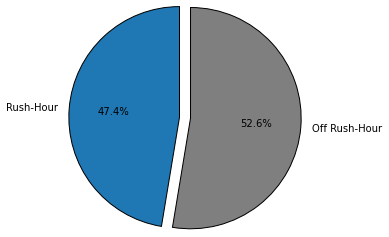

In [7]:
colors = [(31/255., 119/255., 180/255.), (127/255., 127/255., 127/255.)]

plt.pie([sub[sub['rushhour'] == 1].count()[1], sub[sub['rushhour'] == 0].count()[1]],
        labels=['Rush-Hour', 'Off Rush-Hour'],
        colors=(colors[0], colors[1]), explode=(0,0.1),
        autopct='%1.1f%%', startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

plt.show()

For the months tested (January, April and August 2015), slightly more than half of the trips occured during the off rush-hour range that we defined (not between 7-9 am and 4-7pm).